<a href="https://colab.research.google.com/github/look4pritam/ArtificialIntelligence/blob/master/ConvolutionalNeuralNetwork/Notebooks/TransferLearning/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Convolutional Neural Network

In this assignment, we will learn to classify images using [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network). 

We will use TensorFlow flower dataset for classification. 

See [link](https://www.tensorflow.org/datasets/catalog/tf_flowers) for more details on the dataset.

## Set the root directory for processing.

In [2]:
import os

root_dir = '/content/'
os.chdir(root_dir)

!ls -al

total 16
drwxr-xr-x 1 root root 4096 Dec 16 21:15 .
drwxr-xr-x 1 root root 4096 Dec 20 08:32 ..
drwxr-xr-x 4 root root 4096 Dec 16 21:14 .config
drwxr-xr-x 1 root root 4096 Dec 16 21:15 sample_data


## Import required python modules.

In [4]:
import numpy as np
np.random.seed(7)

In [5]:
import tensorflow as tf
tf.random.set_seed(7)

import tensorflow_datasets as tfds

In [6]:
from tensorflow import keras

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D

In [7]:
dataset_name = 'oxford_flowers102'
splits = ['test', 'validation', 'train']
dataset, dataset_info = tfds.load(dataset_name, split = splits, with_info=True, as_supervised=True)
(train_examples, validation_examples, test_examples) = dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete4E8P73/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete4E8P73/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete4E8P73/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


Number of flower types 102
Number of training examples: 6149
Number of validation examples: 1020
Number of test examples: 1020

Flower types full list:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion'

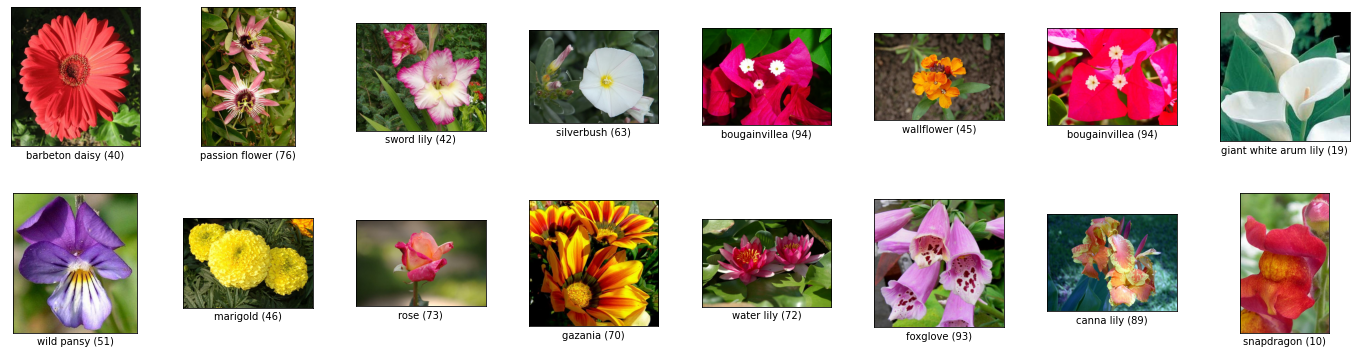

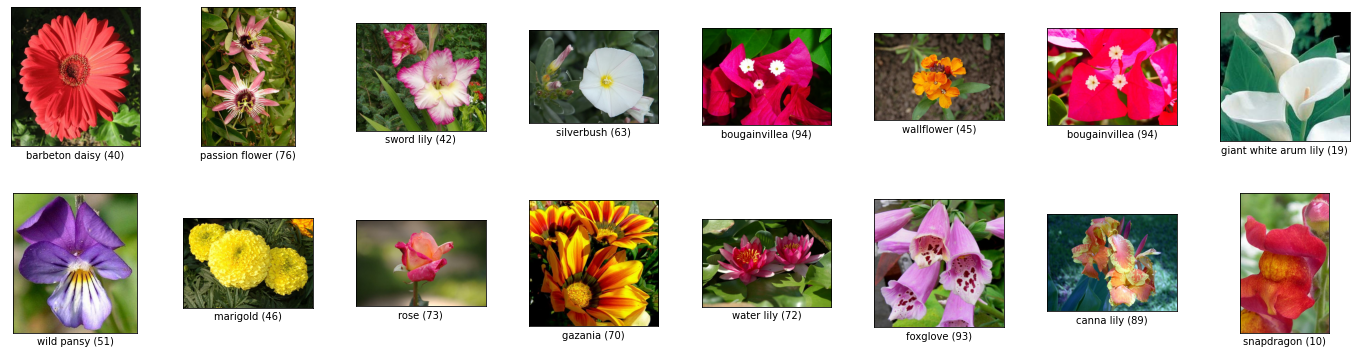

In [8]:
print(f"Number of flower types {dataset_info.features['label'].num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}\n")

print('Flower types full list:')
print(dataset_info.features['label'].names)

tfds.show_examples(train_examples, dataset_info, rows=2, cols=8)

In [9]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [10]:
def format_example(input_image, input_label):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image / 255.0

    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))

    return(input_image, input_label)

In [11]:
train = train_examples.map(format_example)
validation = validation_examples.map(format_example)
test = test_examples.map(format_example)

In [12]:
def augment_data(image, label):

  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)

  return image, label

train = train.map(augment_data)

In [13]:
buffer_size = 1024
batch_size = 32

train = train.shuffle(buffer_size).batch(batch_size)
validation = validation.batch(batch_size)
test = test.batch(batch_size)

train = train.prefetch(tf.data.experimental.AUTOTUNE)
train = train.repeat()
validation = validation.repeat()
test = test.repeat()

print(train)
print(validation)
print(test)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [14]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

## Define CNN based classification model.

In [15]:
from tensorflow import keras

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

In [19]:
def build_model():
    
    input_image = base_model.input

    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    predictions = keras.layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')(x)

    model = keras.Model(inputs=input_image, outputs=predictions)   

    return (model)

In [ ]:
model = build_model()
model.summary()

## Compile the model.
- Use Adam optimizer.
- Use as a loss function.
- Use as a performance metric.


In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Define callback functions.
- Define callback function to reduce learning rate after saturation.
- Define callback function for early stopping.

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.00001)

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1, mode='auto')

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [25]:
print(tf.data.experimental.cardinality(train_examples).numpy())

6149


In [26]:
steps_per_epoch = round(tf.data.experimental.cardinality(train_examples).numpy())//batch_size
validation_steps = round(tf.data.experimental.cardinality(validation_examples).numpy())//batch_size

## Train the model.
- Define number of epochs.
- Define a batch size for training.

In [27]:
epochs = 10

In [28]:
history = model.fit(train, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation, 
                    validation_steps=validation_steps,
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=[reduce_lr, early_stopping, tensorboard_callback])

Epoch 1/10
192/192 [==============================] - 36s 120ms/step - loss: 2.5383 - accuracy: 0.4570 - val_loss: 1.4175 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 2/10
192/192 [==============================] - 29s 148ms/step - loss: 1.2465 - accuracy: 0.7270 - val_loss: 0.8915 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 3/10
192/192 [==============================] - 29s 150ms/step - loss: 0.9596 - accuracy: 0.7850 - val_loss: 0.7120 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 4/10
192/192 [==============================] - 28s 148ms/step - loss: 0.7884 - accuracy: 0.8241 - val_loss: 0.6198 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 5/10
192/192 [==============================] - 26s 135ms/step - loss: 0.7577 - accuracy: 0.8282 - val_loss: 0.5559 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 6/10
192/192 [==============================] - 26s 137ms/step - loss: 0.6327 - accuracy: 0.8635 - val_loss: 0.5111 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 7/10
192/192 [==============================] 

In [29]:
base_model.trainable = True
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(train, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation, 
                    validation_steps=validation_steps,
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=[reduce_lr, early_stopping, tensorboard_callback])

Epoch 1/10
192/192 [==============================] - 57s 250ms/step - loss: 1.0512 - accuracy: 0.7254 - val_loss: 31.6526 - val_accuracy: 0.0585 - lr: 0.0010
Epoch 2/10
192/192 [==============================] - 48s 247ms/step - loss: 0.4973 - accuracy: 0.8615 - val_loss: 30.2010 - val_accuracy: 0.0504 - lr: 0.0010
Epoch 3/10
192/192 [==============================] - 49s 255ms/step - loss: 0.3875 - accuracy: 0.8908 - val_loss: 16.2289 - val_accuracy: 0.1310 - lr: 0.0010
Epoch 4/10
192/192 [==============================] - 49s 257ms/step - loss: 0.3259 - accuracy: 0.9073 - val_loss: 44.4427 - val_accuracy: 0.0181 - lr: 0.0010
Epoch 5/10
192/192 [==============================] - 47s 245ms/step - loss: 0.3031 - accuracy: 0.9158 - val_loss: 24.7808 - val_accuracy: 0.0675 - lr: 0.0010
Epoch 6/10
192/192 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.9165
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
192/192 [=======================

## Visualize the training graphs.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

## Evaluate the trained model.

In [31]:
evaluation_data = model.evaluate(test, steps=validation_steps)
print('Validation loss - {0:.4f}'.format(evaluation_data[0]))
print('Validation accuracy - {0:.4f}'.format(evaluation_data[1]))

31/31 [==============================] - 3s 96ms/step - loss: 1.9506 - accuracy: 0.7087
Validation loss - 1.9506
Validation accuracy - 0.7087
